# Lab 05 and 06 Data Preprocessing

## Overview

In this lab, we'll continue building on our data understanding by addressing issues that prevent meaningful analysis — namely, data quality and structure.

We remain within the CRISP-DM framework, moving from "Data Understanding" to "Data Preparation." Preprocessing is a key step in this phase, helping us to:

- Handle missing values and inconsistent formats. 
- Identify and manage outliers. 
- Create features that better reflect business behavior. 

This class:
- Scale our numerical data to prevent features with larger scales from dominating the algorithm. 
- Encode the necessary features. 

Essentially, ensure our data is suitable for clustering and other modeling tasks. Without preprocessing, any clustering results would be unreliable or misleading. Clean, consistent data is essential for drawing valid business insights.

In [10]:
# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import sqlite3
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from itertools import product
from scipy.stats import skewnorm

from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Setting seaborn style
sns.set()

# Context
The data we will be using through the pratical classes comes from a small relational database whose schema can be seen below:
![alt text](../figures/schema.png "Relation database schema")

# Reading the Data

In [11]:
# path to database
my_path = os.path.join("..", "data", "datamining.db")

# connect to the database
conn = sqlite3.connect(my_path)

# the query
query = """
select
    age, 
    income, 
    frq, 
    rcn, 
    mnt, 
    clothes, 
    kitchen, 
    small_appliances, 
    toys, 
    house_keeping,
    dependents, 
    per_net_purchase,
    g.gender, 
    e.education, 
    m.status, 
    r.description
from customers as c
    join genders as g on g.id = c.gender_id
    join education_levels as e on e.id = c.education_id
    join marital_status as m on m.id = c.marital_status_id
    join recommendations as r on r.id = c.recommendation_id
order by c.id;
"""

df = pd.read_sql_query(query, conn)

## Make a copy of your original dataset

why?

In [12]:
df_original = df.copy()

# Metadata
- *id* - The unique identifier of the customer
- *age* - The year of birht of the customer
- *income* - The income of the customer
- *frq* - Frequency: number of purchases made by the customer
- *rcn* - Recency: number of days since last customer purchase
- *mnt* - Monetary: amount of € spent by the customer in purchases
- *clothes* - Number of clothes items purchased by the customer
- *kitchen* - Number of kitchen items purchased by the customer
- *small_appliances* - Number of small_appliances items purchased by the customer
- *toys* - Number of toys items purchased by the customer
- *house_keeping* - Number of house_keeping items purchased by the customer
- *dependents* - Binary. Whether or not the customer has dependents
- *per_net_purchase* - Percentage of purchases made online
- *education* - Education level of the customer
- *status* - Marital status of the customer
- *gender* - Gender of the customer
- *description* - Last customer's recommendation description

## Problems:
- Duplicates?
- Data types?
- Missing values?
- Strange values?
- Descriptive statistics?

### Take a closer look and point out possible problems:

(hint: a missing values in pandas is represented with a NaN value)

### Replicating modifications from previous notebook

In [13]:
# replace "" by nans
df.replace("", np.nan, inplace=True)

# count of missing values
df.isna().sum()

/var/folders/jb/jm3xb4f53hs9mcvbg93nks7h0000gn/T/ipykernel_43105/3385904135.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("", np.nan, inplace=True)


age                   0
income               46
frq                   0
rcn                   0
mnt                   0
clothes               0
kitchen               0
small_appliances      0
toys                  0
house_keeping         0
dependents          282
per_net_purchase      0
gender                0
education            47
status              177
description           0
dtype: int64

In [14]:
# fix wrong dtypes
df.dependents = df.dependents.astype("boolean")  # converting to "boolean" over "bool" allows preservation of NaNs

In [15]:
#Define metric and non-metric features. Why?
non_metric_features = ["education", "status", "gender", "dependents", "description"]
metric_features = df.columns.drop(non_metric_features).to_list()

# Data Preprocessing

## Fill missing values

https://statisticsbyjim.com/basics/missing-data/

---
<br>

Read: Section 2.4.2 

Han, J., Pei, J., & Tong, H. (2022). *Data mining: Concepts and Techniques* (4th ed.). Morgan Kaufmann.

<br>

Read: Chapter 4

García, S., Luengo, J., & Herrera, F. (2014). *Data preprocessing in data mining*. Springer.

In [16]:
# Creating a copy to apply central tendency measures imputation
df_central = df.copy()

In [17]:
# count of missing values
df_central.isna().sum()

age                   0
income               46
frq                   0
rcn                   0
mnt                   0
clothes               0
kitchen               0
small_appliances      0
toys                  0
house_keeping         0
dependents          282
per_net_purchase      0
gender                0
education            47
status              177
description           0
dtype: int64

In [18]:
medians = df_central[metric_features].median()

#### What about non-numeric features?

In [19]:
# Check each step of these commands
modes = df_central[non_metric_features].mode().loc[0]

In [20]:
# Fill NaNs on df_central
# CODE HERE

df_central[metric_features] = df_central[metric_features].fillna(medians)
df_central[non_metric_features] = df_central[non_metric_features].fillna(modes)

df_central.isna().sum()  # checking how many NaNs we still have

age                 0
income              0
frq                 0
rcn                 0
mnt                 0
clothes             0
kitchen             0
small_appliances    0
toys                0
house_keeping       0
dependents          0
per_net_purchase    0
gender              0
education           0
status              0
description         0
dtype: int64

In [21]:
# let's keep the central imputation
df = df_central.copy()

## An overview of our previous data exploration

You can also explore this dataset using the exported `pandas-profiling` report.




![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/categorical_variables_counts.png)

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/numeric_variables_histograms.png)

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/numeric_variables_boxplots.png)

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/pairwise_numeric_scatterplots.png)

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/correlation_matrix.png)

## Outlier removal

Why do we need to remove outliers? Which methods can we use?




### Outlier removal using only the IQR method

Why should you use/not use this method?

Inter-Quartile Range formula:

<br>

$IQR = Q_3 – Q_1$

<br>

---

<br>

**Outliers** are the observations that fall
- below $Q_1 − 1.5 \times IQR$

or

- above $Q_3 + 1.5 \times IQR$

<br>
<br>

https://online.stat.psu.edu/stat200/lesson/3/3.2

In [22]:
# Compute the IQR
# HINT: Use .quantile()

# Calculate Q1, Q3, IQR

q1 = df[metric_features].quantile(.25)


In [23]:
# Calculate Q1, Q3, IQR

q3 = df[metric_features].quantile(.75)


In [24]:
# Calculate Q1, Q3, IQR

iqr = (q3 - q1)


In [25]:
# Compute upper and lower limit 

# lower_limit = Q1 -1.5*IQR
lower_lim = q1 - (1.5 * iqr)

# upper_limit = Q3 + 1.5*IQR
upper_lim = q3 + (1.5 * iqr)




In [26]:
filters_iqr = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters_iqr.append(df[metric].between(llim, ulim, inclusive='neither'))

filters_iqr_all = pd.Series(np.all(filters_iqr, 0))


In [27]:
filters_iqr_all.sum()

np.int64(7339)

In [28]:
df_iqr = df[filters_iqr_all]
print('Percentage of data kept after removing outliers:', 100*(np.round(df_iqr.shape[0] / df_original.shape[0], 4)))


Percentage of data kept after removing outliers: 81.56


What do you think of this number?

In general we want to keep as much of our data as possible.

As a rule of thumb, try not to remove more than 5% of your rows. 

***This is only a rule of thumb!*** 

In some cases it really is necessary to remove more.


### Manual outlier removal

Now let's try "manually" filtering the dataset's outliers

---


Let's look at the boxplots again:

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/numeric_variables_boxplots.png)

In [29]:
# This may vary from session to session, and is prone to varying interpretations.
# A simple example is provided below:

# ( df['feature1']<= limit1 ) & ( df['feature2']<= limit2 ) ...


filters_man = (
    (df['house_keeping']<=50)
    &
    (df['kitchen']<=40)
    &
    (df['toys']<=35)
    &
    (df['education']!='OldSchool')
)

df_man = df[filters_man]

In [30]:
print('Percentage of data kept after removing outliers:', 100*np.round(df_man.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers: 97.99


## Combining different outlier methods

More robust/ consistent outlier detection method:

In [31]:
## What is this doing?
df_out = df[(filters_iqr_all | filters_man)] 


print('Percentage of data kept after removing outliers:', np.round(df_out.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers: 0.9819


In [32]:
# Get the manual filtering version

df = df_man.copy()



## Outlier threshold value

You may change the values of observations for a given variable:


In [33]:
print((df['rcn']>100).value_counts())

rcn_t = df['rcn'].copy()
rcn_t.loc[rcn_t>100] = 100

df['rcn'] = rcn_t

rcn
False    8437
True      380
Name: count, dtype: int64



Visualize your boxplots and histograms before and after outlier removal.


![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/boxplots_before_after_outliers.png)

## Feature Engineering

A reminder of our metadata:
- *id* - The unique identifier of the customer
- *age* - The year of birht of the customer
- *income* - The income of the customer
- *frq* - Frequency: number of purchases made by the customer
- *rcn* - Recency: number of days since last customer purchase
- *mnt* - Monetary: amount of € spent by the customer in purchases
- *clothes* - Number of clothes items purchased by the customer
- *kitchen* - Number of kitchen items purchased by the customer
- *small_appliances* - Number of small_appliances items purchased by the customer
- *toys* - Number of toys items purchased by the customer
- *house_keeping* - Number of house_keeping items purchased by the customer
- *dependents* - Binary. Whether or not the customer has dependents
- *per_net_purchase* - Percentage of purchases made online
- *education* - Education level of the customer
- *status* - Marital status of the customer
- *gender* - Gender of the customer
- *description* - Last customer's recommendation description

In [34]:
# Try to pull as many features as you can; You can always drop them later on
# You can start by converting the 'age' variable to the actual age
# You can also store the birth year in another feature

# CODE HERE

In [35]:
new_features = []

In [36]:
df['birth_year'] = df['age']
df['age'] = 2024 - df['birth_year']
new_features.append('birth_year')

new_features

['birth_year']

In [37]:
df.describe()

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,birth_year
count,8817.000000,8817.000000,8817.000000,8817.000000,8817.000000,8817.000000,8817.000000,8817.000000,8817.000000,8817.000000,8817.000000,8817.000000
mean,58.335261,70534.387887,19.990360,52.220937,630.162640,51.181127,6.776908,28.673925,6.581263,6.764319,42.241239,1965.664739
std,17.075958,27246.776600,10.918369,30.098895,647.834648,22.984454,7.310850,12.595621,6.895266,7.540019,18.482272,17.075958
min,28.000000,10000.000000,3.000000,0.000000,6.000000,1.000000,0.000000,1.000000,0.000000,0.000000,4.000000,1936.000000
25%,44.000000,48842.000000,10.000000,26.000000,64.000000,34.000000,2.000000,19.000000,2.000000,2.000000,27.000000,1951.000000
50%,58.000000,70388.000000,18.000000,53.000000,387.000000,52.000000,4.000000,28.000000,4.000000,4.000000,45.000000,1966.000000
75%,73.000000,92413.000000,28.000000,78.000000,1079.000000,70.000000,9.000000,37.000000,9.000000,9.000000,57.000000,1980.000000
max,88.000000,140628.000000,59.000000,100.000000,3052.000000,99.000000,40.000000,74.000000,35.000000,50.000000,88.000000,1996.000000


In [38]:
df['spent_online'] = df['per_net_purchase']*df['mnt']/100

new_features.append('spent_online')

new_features

['birth_year', 'spent_online']

In [39]:
metric_features.append('spent_online')
metric_features.append('birth_year')
metric_features

['age',
 'income',
 'frq',
 'rcn',
 'mnt',
 'clothes',
 'kitchen',
 'small_appliances',
 'toys',
 'house_keeping',
 'per_net_purchase',
 'spent_online',
 'birth_year']

## Variable selection: Redundancy VS Relevancy

### Redundancy: Handling highly correlated variables

We already saw our original correlation matrix:

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/correlation_matrix.png)


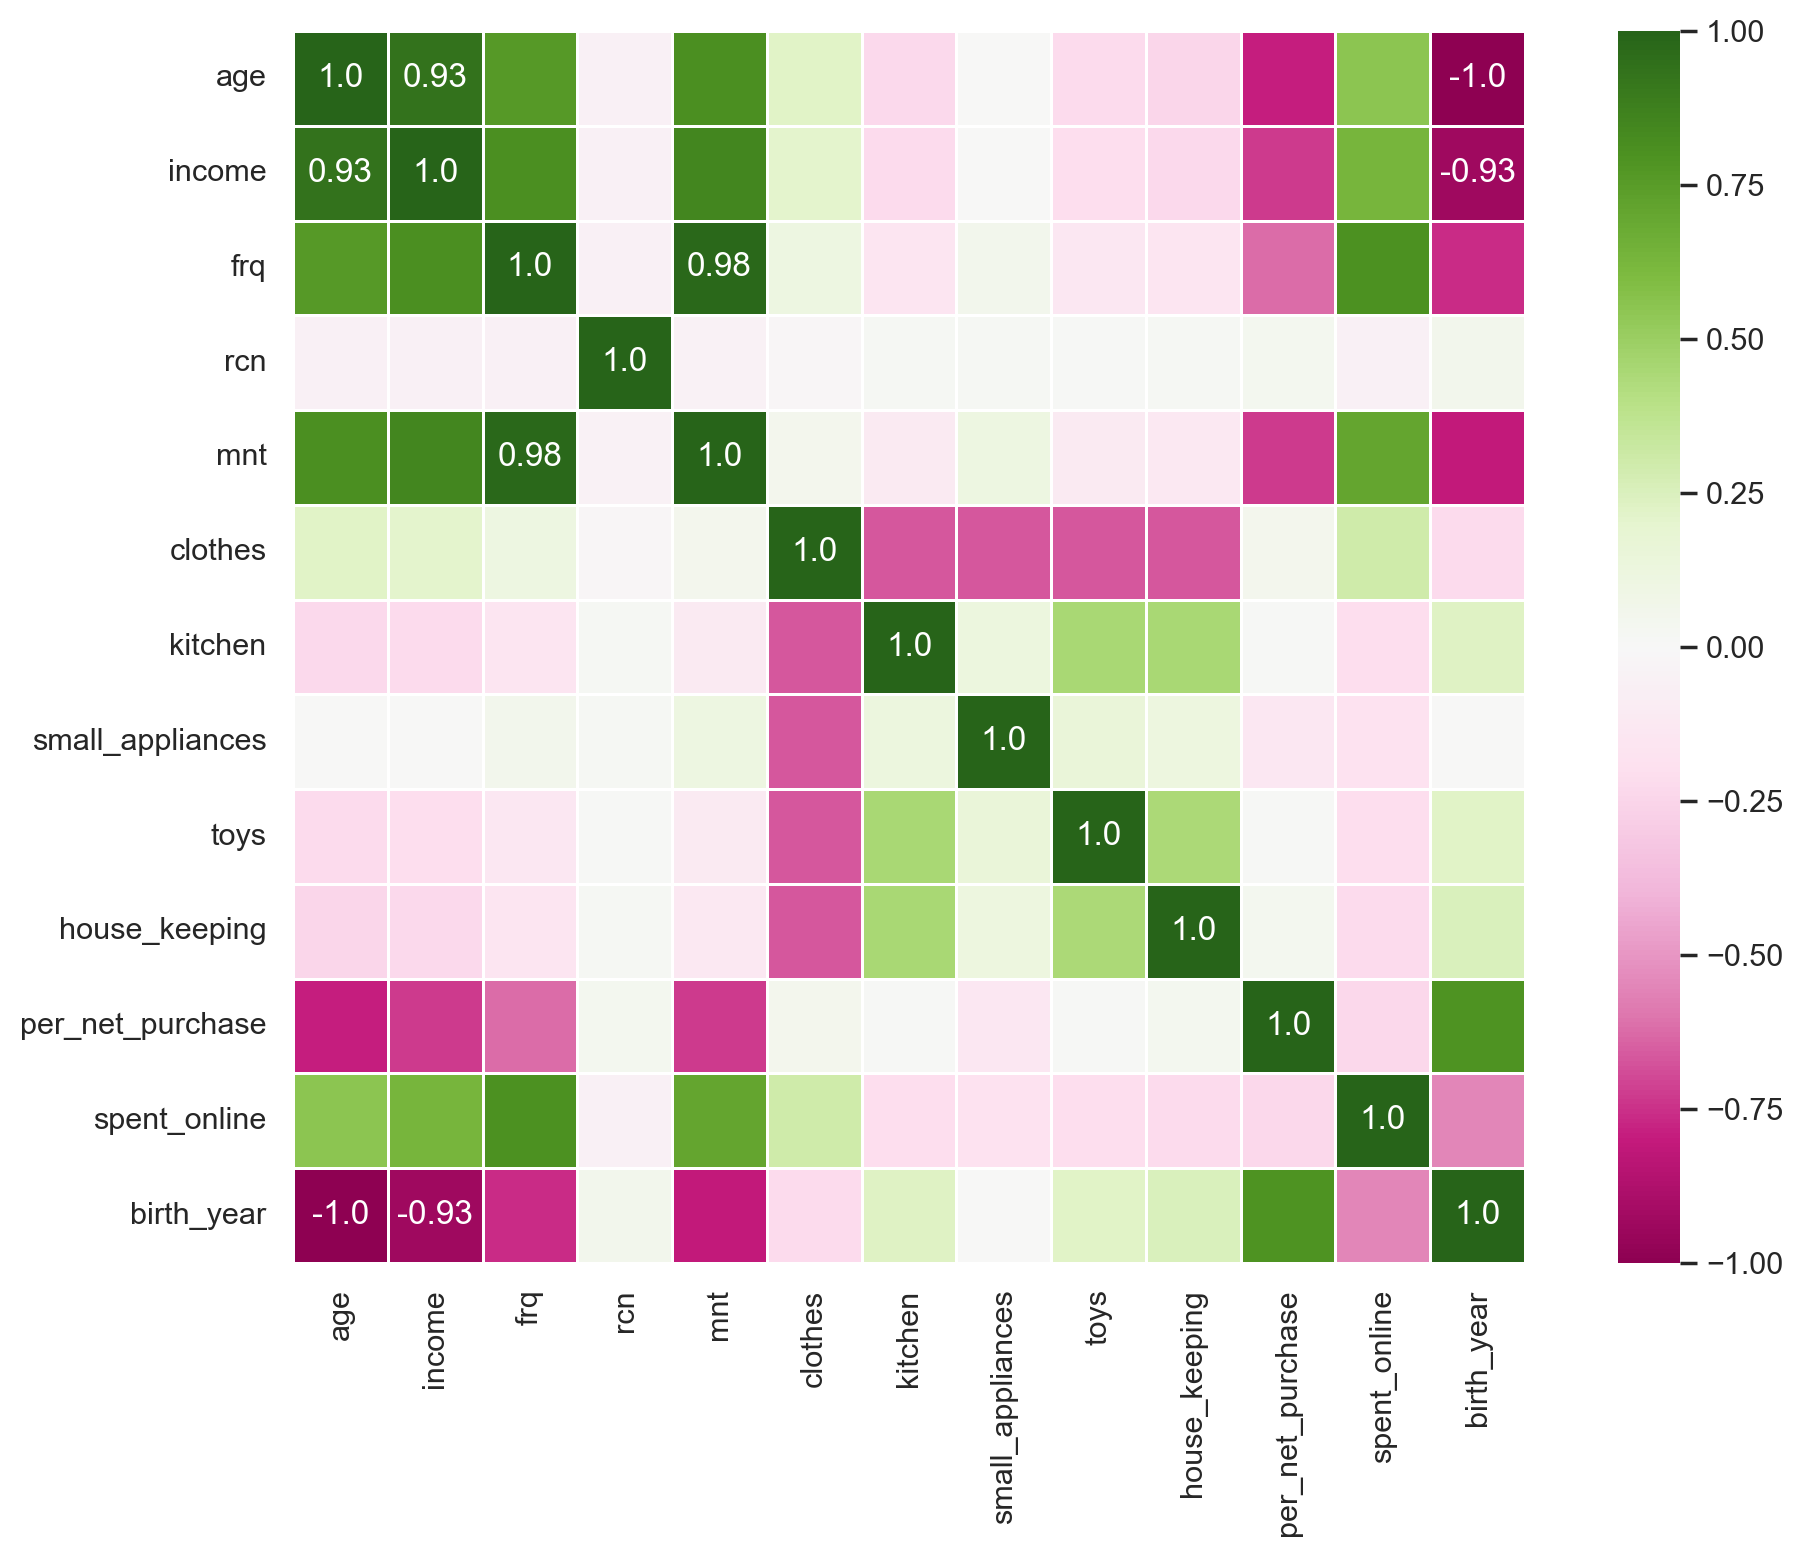

In [40]:
plt.figure(figsize=(12,8))
corr = df[metric_features].corr()
corr = corr.round(2)

sns.heatmap(
    corr,
    center = 0,
    cmap='PiYG',
    annot=np.where(np.absolute(corr) >= 0.9, corr.values, np.full(corr.values.shape, "")),
    fmt='s',
    square=True,
    linewidths=.5,
)
plt.show()

In [41]:
# Select variables according to their correlations
# Updating metric_features

## RUN THIS CELL ONLY ONCE!!!!

# CODE HERE
metric_features.remove("mnt")
metric_features.remove("age")
metric_features.remove("birth_year")

metric_features


['income',
 'frq',
 'rcn',
 'clothes',
 'kitchen',
 'small_appliances',
 'toys',
 'house_keeping',
 'per_net_purchase',
 'spent_online']

In [42]:
# You can also drop the features from the df
# But sometimes they may be useful for cluster profiling later

# df.drop(..., inplace=True)


### Relevancy
Selecting variables based on the relevancy of each one to the task. 

Example: 
- remove uncorrelated variables with the target,
- stepwise regression,
- use variables for product clustering,
- use variables for socio-demographic clustering,
- ...

Variables that aren't correlated with any other variable are often also not relevant. In this case we will not focus on this a lot since we don't have a defined task yet.

## Redo data exploration

Check if the data looks the way you expect it to. 

- Have you missed some outliers? 
- Are there still missing values?
- Is the data normalized?

This is an iterative process. It is likely you will change your preprocessing steps frequently throughout your group work.

# Begginning of lab 06

## Data Normalization / Scaling

In [43]:
# Remember our original data

df.describe().round(2)

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,birth_year,spent_online
count,8817.00,8817.00,8817.00,8817.00,8817.00,8817.00,8817.00,8817.00,8817.00,8817.00,8817.00,8817.00,8817.00
mean,58.34,70534.39,19.99,52.22,630.16,51.18,6.78,28.67,6.58,6.76,42.24,1965.66,178.38
std,17.08,27246.78,10.92,30.10,647.83,22.98,7.31,12.60,6.90,7.54,18.48,17.08,168.58
min,28.00,10000.00,3.00,0.00,6.00,1.00,0.00,1.00,0.00,0.00,4.00,1936.00,2.73
25%,44.00,48842.00,10.00,26.00,64.00,34.00,2.00,19.00,2.00,2.00,27.00,1951.00,34.65
50%,58.00,70388.00,18.00,53.00,387.00,52.00,4.00,28.00,4.00,4.00,45.00,1966.00,140.00
75%,73.00,92413.00,28.00,78.00,1079.00,70.00,9.00,37.00,9.00,9.00,57.00,1980.00,265.10
max,88.00,140628.00,59.00,100.00,3052.00,99.00,40.00,74.00,35.00,50.00,88.00,1996.00,1416.24


### **MinMax Scaling**

Transforms values to be between [0,1]

$$
x' = \frac{x - min(X)}{max(X) - min(X)}
$$

<br>
<br>

where:
- x$ is an original value
- $x'$ is the normalized value

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [44]:
## Let's look at an example:

demo_ages = pd.DataFrame({"Age": [14, 24, 22, 18, 18, 26, 11, 23, 13, 12]})
demo_ages

,Age
0,14
1,24
2,22
3,18
4,18
5,26
6,11
7,23
8,13
9,12


In [45]:

# How to do this with Python/Pandas?
#  ( demo_ages - min(demo_ages) ) 
# --------------------------------- 
#  max(demo_ages) - min(demo_ages)

demo_ages


,Age
0,14
1,24
2,22
3,18
4,18
5,26
6,11
7,23
8,13
9,12


#### Exercise `1`: Scale the `age` column with MinMax 

In [46]:
min_age = demo_ages["Age"] # finish this line
max_age = demo_ages["Age"] # finish this line

mm_age = None # finish this line


(This is not showing all rows)


Age (Orig) | Formula        | Result
-----------|----------------|-------
14         | (14 - 11) / 15 | 0.2
24         | (24 - 11) / 15 | 0.86666667
26         | (26 - 11) / 15 | 1
11         | (11 - 11) / 15 | 0






#### Exercise `2`: Use MinMaxScaler from sklearn.preprocessing

In [83]:
# sklearn makes it even easier:

demo_ages["Age_minmax"] = MinMaxScaler()# finish this line

demo_ages

,Age,Age_minmax,Age_standard
0,14,MinMaxScaler(),-0.793614
1,24,MinMaxScaler(),1.142031
2,22,MinMaxScaler(),0.754902
3,18,MinMaxScaler(),-0.019356
4,18,MinMaxScaler(),-0.019356
5,26,MinMaxScaler(),1.529160
6,11,MinMaxScaler(),-1.374308
7,23,MinMaxScaler(),0.948466
8,13,MinMaxScaler(),-0.987179
9,12,MinMaxScaler(),-1.180743


#### Exercise `3`: Apply MinMaxScaler to the dataset

In [84]:
df_minmax = df.copy()

In [85]:
# Use MinMaxScaler to scale the data
mm_scaler = MinMaxScaler()
mm_scaled_feat = None # finish this line
mm_scaled_feat

In [86]:
# See what the fit method is doing (notice the trailing underscore):
# print("Parameters fitted:\n")
# pd.DataFrame([mm_scaler.data_min_, mm_scaler.data_max_], columns=metric_features, index=['min','max'])

In [87]:
## Replace original metric_features values with mm_scaled_feat values
df_minmax[metric_features] = mm_scaled_feat

In [88]:
# Checking max and min of minmaxed variables
df_minmax[metric_features].describe().T.round(2)

,count,unique,top,freq
income,0,0,NaN,NaN
frq,0,0,NaN,NaN
rcn,0,0,NaN,NaN
clothes,0,0,NaN,NaN
kitchen,0,0,NaN,NaN
small_appliances,0,0,NaN,NaN
toys,0,0,NaN,NaN
house_keeping,0,0,NaN,NaN
per_net_purchase,0,0,NaN,NaN
spent_online,0,0,NaN,NaN


In [89]:
df_minmax[metric_features].head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online
0,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None


In [90]:
df[metric_features].head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online
0,90782.0,33,66,37,5,44,10,3,19,266.38
1,113023.0,32,6,55,1,38,4,2,9,138.33
2,28344.0,11,69,32,19,24,1,24,59,25.96
3,93571.0,26,10,60,10,19,6,5,35,310.80
4,91852.0,31,26,59,5,28,4,4,34,386.92


### **Standard Scaling**

AKA Z-Score Scaling

Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

$$
z = \frac{x - \mu}{\sigma}
$$

where:

- $u$ is the mean of the training samples,
- $\sigma$ is the standard deviation of the training samples

The standard deviation $\sigma$ is given by:

$$
\sigma = \sqrt{\frac{\sum_{i=1}^{N} (x_i - \bar{x})^2}{N - \text{ddof}}}
$$

where:

- $x_i$ = each data point  
- $\bar{x}$ = mean of the data  
- $N$ = number of observations  
- $\text{ddof}$ = delta degrees of freedom  
    - ddof = 0 in population 
    - ddof = 1 in sample

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

#### `Intuition exercise`

If a original feature had:

- Mean (𝜇) = 40
- Standard deviation (𝜎) = 10

Your data was [30, 40, 50]

What will be the values scaled with z-score ? 

In [56]:
## Let's see the age demo again

demo_ages


,Age,Age_minmax
0,14,MinMaxScaler()
1,24,MinMaxScaler()
2,22,MinMaxScaler()
3,18,MinMaxScaler()
4,18,MinMaxScaler()
5,26,MinMaxScaler()
6,11,MinMaxScaler()
7,23,MinMaxScaler()
8,13,MinMaxScaler()
9,12,MinMaxScaler()


In [ ]:
## u = mean of age
## s = std of age

# How to do this in Python/Pandas?
# ( demo_ages - mean(demo_ages) )
# -------------------------------
#        std(demo_ages)

In [57]:
## u = mean of age
## s = std of age

mean_age = demo_ages["Age"].mean()
std_age  = demo_ages["Age"].std(ddof = 0) # to match sklearn implementation of std


In [58]:
(demo_ages["Age"] - mean_age) / std_age

0   -0.793614
1    1.142031
2    0.754902
3   -0.019356
4   -0.019356
5    1.529160
6   -1.374308
7    0.948466
8   -0.987179
9   -1.180743
Name: Age, dtype: float64

In [59]:
# Or use sklearn:

demo_ages["Age_standard"] = StandardScaler().fit_transform(demo_ages[["Age"]])

demo_ages

,Age,Age_minmax,Age_standard
0,14,MinMaxScaler(),-0.793614
1,24,MinMaxScaler(),1.142031
2,22,MinMaxScaler(),0.754902
3,18,MinMaxScaler(),-0.019356
4,18,MinMaxScaler(),-0.019356
5,26,MinMaxScaler(),1.529160
6,11,MinMaxScaler(),-1.374308
7,23,MinMaxScaler(),0.948466
8,13,MinMaxScaler(),-0.987179
9,12,MinMaxScaler(),-1.180743


In [60]:
demo_ages.describe().round(2)

,Age,Age_standard
count,10.00,10.00
mean,18.10,-0.00
std,5.45,1.05
min,11.00,-1.37
25%,13.25,-0.94
50%,18.00,-0.02
75%,22.75,0.90
max,26.00,1.53


#### Exercise `4`: Apply StandardScaler to the dataset

In [61]:
df_standard = df.copy()

In [62]:
ss_scaler = None # finish this line
ss_scaled_feat = None # finish this line
ss_scaled_feat

In [64]:
# See what the fit method is doing (notice the trailing underscore):
print("Parameters fitted:\n")
# pd.DataFrame([ss_scaler.mean_, np.sqrt(ss_scaler.var_)], columns=metric_features, index=['mean','std'])

Parameters fitted:



In [65]:
df_standard[metric_features] = ss_scaled_feat
df_standard.head()

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,dependents,per_net_purchase,gender,education,status,description,birth_year,spent_online
0,78,None,None,None,1402,None,None,None,None,None,False,None,M,Graduation,Together,Take my money!!,1946,None
1,88,None,None,None,1537,None,None,None,None,None,False,None,F,PhD,Divorced,Take my money!!,1936,None
2,34,None,None,None,44,None,None,None,None,None,True,None,M,Graduation,Married,Kind of OK,1990,None
3,69,None,None,None,888,None,None,None,None,None,True,None,F,Master,Married,OK nice!,1955,None
4,69,None,None,None,1138,None,None,None,None,None,True,None,F,Graduation,Together,Take my money!!,1955,None


In [66]:
# Checking mean and variance of standardized variables
df_standard[metric_features].describe().round(2)

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online
count,0,0,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### `Intuition exercise` 
- What if we had a training and test set? 
- Should we fit a Scaler in both? 
- What about other Sklearn objects?

## Compare MinMaxScaler vs StandardScaler vs Original data

### Boxplots

ValueError: List of boxplot statistics and `positions` values must have same the length

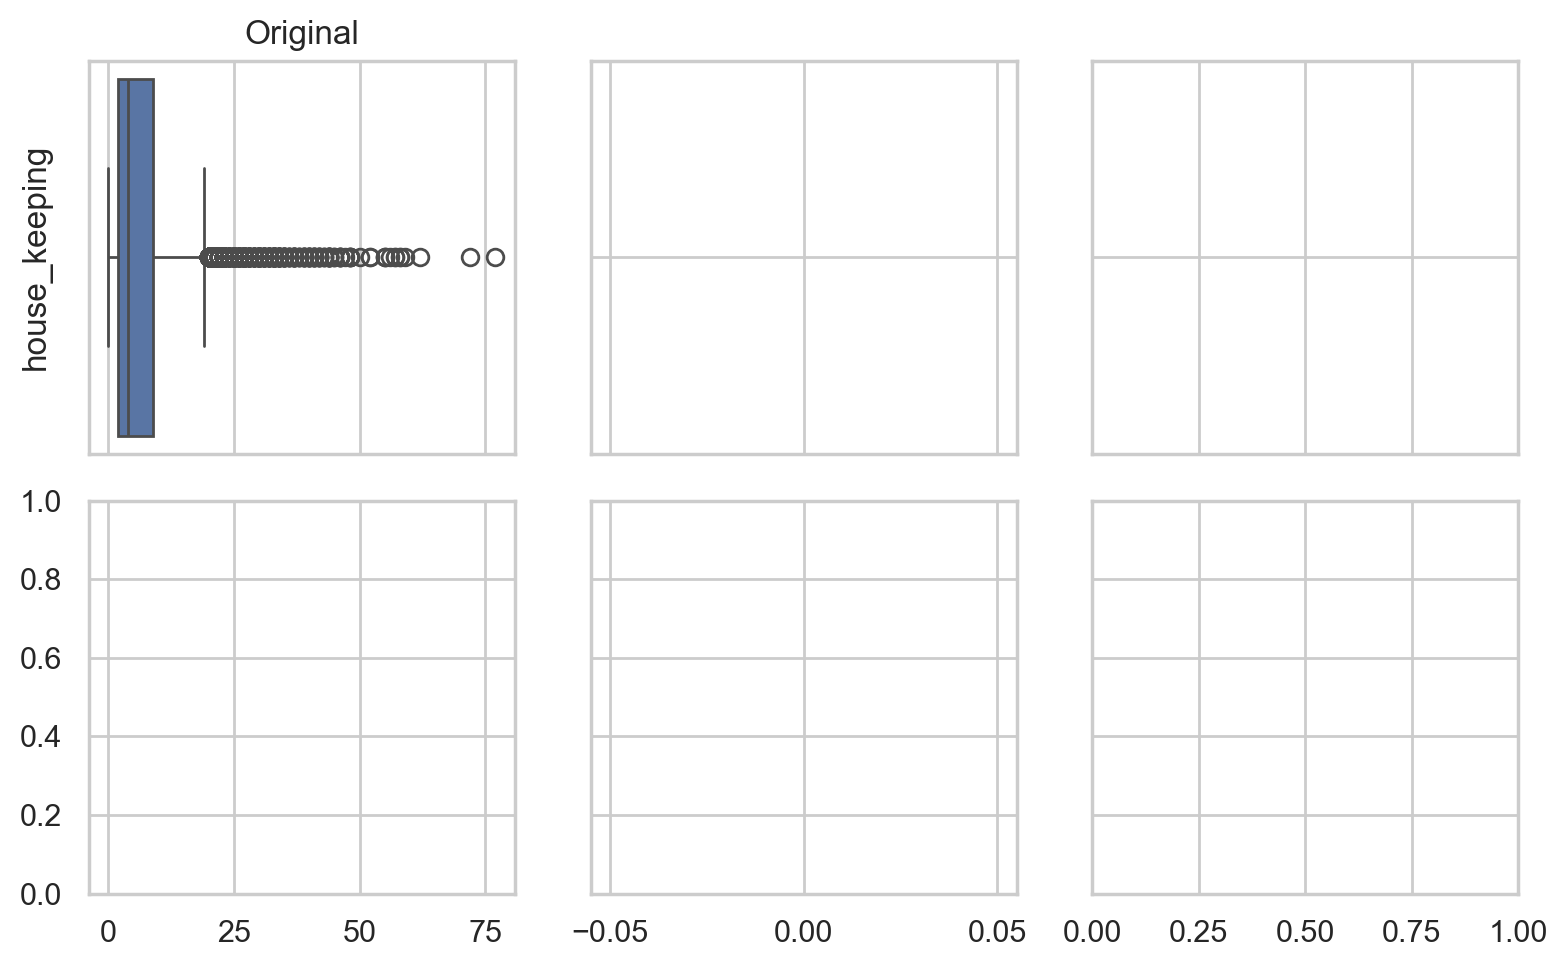

In [ ]:

sns.set_style('whitegrid')
fig, axes = plt.subplots(2,3, figsize=(8,5), tight_layout=True, sharex='col', sharey='row')

bp_feat_l = 'house_keeping'

sns.boxplot(df_original, x=bp_feat_l, ax=axes[0][0], width=.4)
axes[0][0].set_title('Original')
axes[0][0].set_ylabel(bp_feat_l)

sns.boxplot(df_minmax, x=bp_feat_l, ax=axes[0][1], width=.4)
axes[0][1].set_title('MinMaxScaler()')

sns.boxplot(df_standard, x=bp_feat_l, ax=axes[0][2], width=.4)
axes[0][2].set_title('StandardScaler()')



bp_feat_r = 'income'

sns.boxplot(df_original, x=bp_feat_r, ax=axes[1][0], width=.4)
axes[1][0].set_ylabel(bp_feat_r)

sns.boxplot(df_minmax, x=bp_feat_r, ax=axes[1][1], width=.4)

sns.boxplot(df_standard, x=bp_feat_r, ax=axes[1][2], width=.4)


axes[1][0].set_xlabel(None)
axes[1][1].set_xlabel(None)
axes[1][2].set_xlabel(None)

fig.suptitle('Boxplots: "{}" and "{}"'.format(bp_feat_l, bp_feat_r))
plt.show()

In [ ]:
sns.set_style('white')

fig, axes = plt.subplots(3,1, figsize=(8,5), tight_layout=True,)

sns.boxplot(df, x=bp_feat_l, ax=axes[2], width=.4)
sns.boxplot(df_minmax, x=bp_feat_l, ax=axes[1], width=.4)
sns.boxplot(df_standard, x=bp_feat_l, ax=axes[0], width=.4)

axes[0].set_title("standard")
axes[0].set_xlabel(None)
axes[1].set_title("mm")
axes[1].set_xlabel(None)
axes[2].set_title("origi")
axes[2].set_xlabel(None)

plt.suptitle('Boxplots: "{}"'.format(bp_feat_l))



### Histograms

What about histograms?

#### `Intuition exercise`

- Visualize histograms here, compare the shapes of the original distribution with the MinMaxScaler and StandardScaler results.

In [ ]:
sns.set_style('whitegrid')

# Create subplots with 3 rows, 1 column:
fig, axes = plt.subplots(3,1, 
                         figsize=(5,5), tight_layout=True)

# Which feature do you want to visualize?
hp_feat = 'house_keeping'

# common function args for histplot
hp_args = dict(x=hp_feat, bins=15)


sns.histplot(df_original, ax=axes[0], **hp_args)
axes[0].set_title('{}: Original'.format(hp_feat))
axes[0].set_xlabel(None)

sns.histplot(df_minmax, ax=axes[1], **hp_args)
axes[1].set_title('{}: MinMaxScaler()'.format(hp_feat))
axes[1].set_xlabel(None)

sns.histplot(df_standard, ax=axes[2], **hp_args)
axes[2].set_title('{}: StandardScaler()'.format(hp_feat))
axes[2].set_xlabel(None)


plt.show()

sns.set()

In [ ]:
sns.set()

#### Keep StandardScaler

In [ ]:
df = df_standard.copy()

## **One-hot encoding**

In [ ]:
df_ohc = df.copy()

In [ ]:
df['dependents'] = df['dependents'].fillna(False)

fig, axes = plt.subplots(
    2,
    ceil(len(non_metric_features) / 2),
    figsize=(10,7))

for ax, feat in zip(axes.flatten(), non_metric_features):
    df[feat].value_counts().plot.bar(ax=ax, width=.7)
    ax.set_title(feat)
    ax.set_xlabel(None)
    ax.set_ylabel(None) 
    ax.tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.6)
plt.show()

First let's remove status=Whatever

In [ ]:
df_ohc.loc[df_ohc['status'] == 'Whatever', 'status'] = df['status'].mode()[0]

In [ ]:
# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse_output=False, drop="first") #sparse_output=False outputs a numpy array, not a sparse matrix
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names_out()


In [ ]:
# Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names_out()


In [ ]:
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
ohc_df

In [ ]:
# Reassigning df to contain ohc variables
df_ohc = pd.concat([df_ohc, ohc_df], axis=1)
df_ohc.head()

In [ ]:
df = df_ohc.copy()

In [ ]:
list(df.columns)

In [ ]:
# You can also choose to drop the original non_metric_features from your df
# df.drop(columns=non_metric_features)

### Rename OHE columns

In [ ]:
## Rename OHE columns from "feature_val_a" to "oh_feature_val_a"
## e.g. status_Widow to oh_status_Widow
## We do this to be able to distinguish the OHE columns more easily later

## Assemble OHE columns and their new column names
rename_ohe_cols = {}

for i in non_metric_features:
    for j in df.columns[df.columns.str.startswith(i)].to_list() :
        if j not in non_metric_features:
            rename_ohe_cols[j] = 'oh_' + j

df.rename(columns=rename_ohe_cols, inplace=True)


In [ ]:
df

In [ ]:
list(df.columns)

## Redo data exploration

Check if the data looks the way you expect it to. 

- Have you missed some outliers? 
- Are there still missing values?
- Is the data normalized?

This is an iterative process. It is likely you will change your preprocessing steps frequently throughout your group work.

#### A tool to assist you through your exploratory data analysis

Optionally, you may use `pandas-profiling` in your data analysis. 

Remember, although this tool provides excelent insights about the data you're working with, it is not enough to perform a proper analysis.

In [ ]:

# ProfileReport(
#     df,
#     title='Tugas Customer Data Preprocessed',
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": False},
#         "kendall": {"calculate": False},
#         "phi_k": {"calculate": False},
#         "cramers": {"calculate": False},
#     },
# )